# Configuration

In [1]:
from datetime import datetime
import os
import random

from colorama import Fore

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils

import numpy as np

import matplotlib.animation as animation
import matplotlib.pyplot as plt

from IPython.display import HTML

In [2]:
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

In [3]:
manualSeed = 999
# manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)

Random Seed:  999


In [4]:
OUTPUT_DIRECTORY = "output"
os.makedirs(OUTPUT_DIRECTORY, exist_ok=True)

In [5]:
image_size = 32
batch_size = 128

learning_rate = 0.0002
beta1 = 0.5
beta2 = 0.999

# Loading data

In [6]:
DATASET_PATH = "../data/cifar10"


def get_cifar_loader_configuration(is_training: bool):
    return {
        "dataset": datasets.CIFAR10(
            DATASET_PATH,
            train=is_training,
            download=True,
            transform=transforms.Compose(
                [
                    transforms.Resize(image_size),
                    transforms.CenterCrop(image_size),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                ]
            ),
        ),
        "batch_size": batch_size,
        "shuffle": True,
    }

def show_example_from(loader: DataLoader):
    loader.batch_size
    features, labels = next(iter(loader))
    print(f"Feature batch shape: {features.size()}")
    print(f"Labels batch shape: {labels.size()}")
    image = features[0].squeeze()
    label = labels[0]
    image = image.permute(1, 2, 0)  # Change the shape to (32, 32, 3)
    image = (image + 1) / 2  # Adjust the values to [0, 1] range
    plt.imshow(image)
    plt.show()
    print(f"Label: {label}")

100.0%


Extracting ../data/cifar10\cifar-10-python.tar.gz to ../data/cifar10
Files already downloaded and verified
Feature batch shape: torch.Size([128, 3, 32, 32])
Labels batch shape: torch.Size([128])


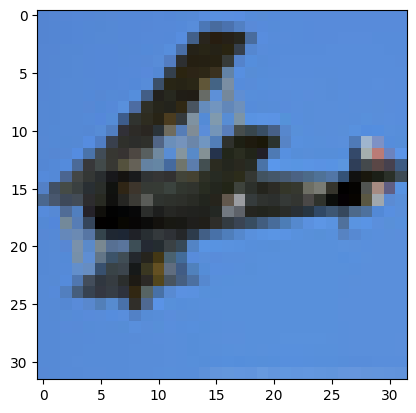

Label: 0
Feature batch shape: torch.Size([128, 3, 32, 32])
Labels batch shape: torch.Size([128])


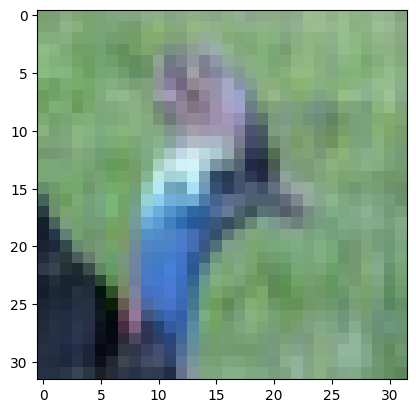

Label: 2


In [7]:
# Use the custom dataset in the data loader
train_dataloader = torch.utils.data.DataLoader(
    **get_cifar_loader_configuration(is_training=True)
)
# Use the custom dataset in the data loader
test_dataloader = torch.utils.data.DataLoader(
    **get_cifar_loader_configuration(is_training=False)
)

show_example_from(train_dataloader)
show_example_from(test_dataloader)

# Models

In [8]:
import numpy as np
import torch
import torch.nn as nn

from einops import rearrange, repeat


class SLN(nn.Module):
    def __init__(self, num_features):
        super(SLN, self).__init__()
        self.ln = nn.LayerNorm(num_features)
        # self.gamma = nn.Parameter(torch.FloatTensor(1, 1, 1))
        # self.beta = nn.Parameter(torch.FloatTensor(1, 1, 1))
        self.gamma = nn.Parameter(torch.randn(1, 1, 1))  # .to("cuda")
        self.beta = nn.Parameter(torch.randn(1, 1, 1))  # .to("cuda")

    def forward(self, hl, w):
        return self.gamma * w * self.ln(hl) + self.beta * w


class MLP(nn.Module):
    def __init__(self, in_feat, hid_feat=None, out_feat=None, dropout=0.0):
        super().__init__()
        if not hid_feat:
            hid_feat = in_feat
        if not out_feat:
            out_feat = in_feat
        self.linear1 = nn.Linear(in_feat, hid_feat)
        self.activation = nn.GELU()
        self.linear2 = nn.Linear(hid_feat, out_feat)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return self.dropout(x)


class Attention(nn.Module):
    def __init__(self, dim, num_heads=4, dim_head=None, discriminator=False):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        self.dim_head = int(dim / num_heads) if dim_head is None else dim_head
        self.weight_dim = self.num_heads * self.dim_head
        self.to_qkv = nn.Linear(dim, self.weight_dim * 3, bias=False)
        self.scale_factor = dim**-0.5
        self.discriminator = discriminator
        self.w_out = nn.Linear(self.weight_dim, dim, bias=True)

        if discriminator:
            u, s, v = torch.svd(self.to_qkv.weight)
            self.init_spect_norm = torch.max(s)

    def forward(self, x):
        assert x.dim() == 3

        if self.discriminator:
            u, s, v = torch.svd(self.to_qkv.weight)
            self.to_qkv.weight = torch.nn.Parameter(
                self.to_qkv.weight * self.init_spect_norm / torch.max(s)
            )

        qkv = self.to_qkv(x)
        q, k, v = tuple(
            rearrange(qkv, "b t (d k h) -> k b h t d", k=3, h=self.num_heads)
        )

        if self.discriminator:
            attn = torch.cdist(q, k, p=2)
        else:
            attn = torch.einsum("... i d, ... j d -> ... i j", q, k)
        scale_attn = attn * self.scale_factor
        scale_attn_score = torch.softmax(scale_attn, dim=-1)
        result = torch.einsum("... i j, ... j d -> ... i d", scale_attn_score, v)
        result = rearrange(result, "b h t d -> b t (h d)")
        return self.w_out(result)


class DEncoderBlock(nn.Module):
    def __init__(self, dim, num_heads=4, dim_head=None, dropout=0.0, mlp_ratio=4):
        super(DEncoderBlock, self).__init__()
        self.attn = Attention(dim, num_heads, dim_head, discriminator=True)
        self.dropout = nn.Dropout(dropout)

        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)

        self.mlp = MLP(dim, dim * mlp_ratio, dropout=dropout)

    def forward(self, x):
        x1 = self.norm1(x)
        x = x + self.dropout(self.attn(x1))
        x2 = self.norm2(x)
        x = x + self.mlp(x2)
        return x


class GEncoderBlock(nn.Module):
    def __init__(self, dim, num_heads=4, dim_head=None, dropout=0.0, mlp_ratio=4):
        super(GEncoderBlock, self).__init__()
        self.attn = Attention(dim, num_heads, dim_head)
        self.dropout = nn.Dropout(dropout)

        self.norm1 = SLN(dim)
        self.norm2 = SLN(dim)

        self.mlp = MLP(dim, dim * mlp_ratio, dropout=dropout)

    def forward(self, hl, x):
        hl_temp = self.dropout(self.attn(self.norm1(hl, x))) + hl
        hl_final = self.mlp(self.norm2(hl_temp, x)) + hl_temp
        return x, hl_final


class GTransformerEncoder(nn.Module):
    def __init__(self, dim, blocks=6, num_heads=8, dim_head=None, dropout=0):
        super(GTransformerEncoder, self).__init__()
        self.blocks = self._make_layers(dim, blocks, num_heads, dim_head, dropout)

    def _make_layers(self, dim, blocks=6, num_heads=8, dim_head=None, dropout=0):
        layers = []
        for _ in range(blocks):
            layers.append(GEncoderBlock(dim, num_heads, dim_head, dropout))
        return nn.Sequential(*layers)

    def forward(self, hl, x):
        for block in self.blocks:
            x, hl = block(hl, x)
        return x, hl


class DTransformerEncoder(nn.Module):
    def __init__(self, dim, blocks=6, num_heads=8, dim_head=None, dropout=0):
        super(DTransformerEncoder, self).__init__()
        self.blocks = self._make_layers(dim, blocks, num_heads, dim_head, dropout)

    def _make_layers(self, dim, blocks=6, num_heads=8, dim_head=None, dropout=0):
        layers = []
        for _ in range(blocks):
            layers.append(DEncoderBlock(dim, num_heads, dim_head, dropout))
        return nn.Sequential(*layers)

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x


class SineLayer(nn.Module):
    def __init__(
        self, in_features, out_features, bias=True, is_first=False, omega_0=30
    ):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 1 / self.in_features)
            else:
                self.linear.weight.uniform_(
                    -np.sqrt(6 / self.in_features) / self.omega_0,
                    np.sqrt(6 / self.in_features) / self.omega_0,
                )

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))


class Generator(nn.Module):
    def __init__(
        self,
        initialize_size=8,
        dim=384,
        blocks=6,
        num_heads=6,
        dim_head=None,
        dropout=0,
        out_channels=3,
    ):
        super(Generator, self).__init__()
        self.initialize_size = initialize_size
        self.dim = dim
        self.blocks = blocks
        self.num_heads = num_heads
        self.dim_head = dim_head
        self.dropout = dropout
        self.out_channels = out_channels

        self.pos_emb1D = nn.Parameter(torch.randn(self.initialize_size * 8, dim))

        self.mlp = nn.Linear(1024, (self.initialize_size * 8) * self.dim)
        self.Transformer_Encoder = GTransformerEncoder(
            dim, blocks, num_heads, dim_head, dropout
        )

        # Implicit Neural Representation
        self.w_out = nn.Sequential(
            SineLayer(dim, dim * 2, is_first=True, omega_0=30.0),
            SineLayer(
                dim * 2,
                self.initialize_size * 8 * self.out_channels,
                is_first=False,
                omega_0=30,
            ),
        )
        self.sln_norm = SLN(self.dim)

    def forward(self, noise):
        x = self.mlp(noise).view(-1, self.initialize_size * 8, self.dim)
        x, hl = self.Transformer_Encoder(self.pos_emb1D, x)
        x = self.sln_norm(hl, x)
        x = self.w_out(x)  # Replace to siren
        result = x.view(
            x.shape[0], 3, self.initialize_size * 8, self.initialize_size * 8
        )
        return result


class Discriminator(nn.Module):
    def __init__(
        self,
        in_channels=3,
        patch_size=8,
        extend_size=2,
        dim=384,
        blocks=6,
        num_heads=6,
        dim_head=None,
        dropout=0,
    ):
        super(Discriminator, self).__init__()
        self.patch_size = patch_size + 2 * extend_size
        self.token_dim = in_channels * (self.patch_size**2)
        self.project_patches = nn.Linear(self.token_dim, dim)

        self.emb_dropout = nn.Dropout(dropout)

        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.pos_emb1D = nn.Parameter(torch.randn(self.token_dim + 1, dim))
        self.mlp_head = nn.Sequential(nn.LayerNorm(dim), nn.Linear(dim, 1))

        self.Transformer_Encoder = DTransformerEncoder(
            dim, blocks, num_heads, dim_head, dropout
        )

    def forward(self, img):
        # Generate overlappimg image patches
        stride_h = (img.shape[2] - self.patch_size) // 8 + 1
        stride_w = (img.shape[3] - self.patch_size) // 8 + 1
        img_patches = img.unfold(2, self.patch_size, stride_h).unfold(
            3, self.patch_size, stride_w
        )
        img_patches = img_patches.contiguous().view(
            img_patches.shape[0],
            img_patches.shape[2] * img_patches.shape[3],
            img_patches.shape[1] * img_patches.shape[4] * img_patches.shape[5],
        )
        img_patches = self.project_patches(img_patches)
        batch_size, tokens, _ = img_patches.shape

        # Prepend the classifier token
        cls_token = repeat(self.cls_token, "() n d -> b n d", b=batch_size)
        img_patches = torch.cat((cls_token, img_patches), dim=1)

        # Plus the positional embedding
        img_patches = img_patches + self.pos_emb1D[: tokens + 1, :]
        img_patches = self.emb_dropout(img_patches)

        result = self.Transformer_Encoder(img_patches)
        logits = self.mlp_head(result[:, 0, :])
        logits = nn.Sigmoid()(logits)
        return logits

# Training loop

In [9]:
# Tracking progress
images = []
G_losses = []
D_losses = []

iterations_passed = 0
number_of_epochs = 15

model_save_interval = 1500
samples_save_interval = 500


def train_on_real_batch():
    discriminator.zero_grad()
    real_cpu = data_batch[0].to(device)
    b_size = real_cpu.size(0)
    label = torch.full((b_size,), 1, dtype=torch.float32, device=device)
    output = discriminator(real_cpu).view(-1)
    errD_real = criterion(output, label)
    errD_real.backward()
    D_x = output.mean().item()
    return D_x, label, b_size, errD_real


def train_on_fake_batch():
    noise = torch.randn(b_size, 100, 1, 1, device=device)
    fake = generator(noise)
    label.fill_(0)
    output = discriminator(fake.detach()).view(-1)
    errD_fake = criterion(output, label)
    errD_fake.backward()
    D_G_z1 = output.mean().item()
    errD = errD_real + errD_fake
    optimizerD.step()
    return noise, fake, D_G_z1, errD


def update_generator_network():
    generator.zero_grad()
    label.fill_(1)  # fake labels are real for generator cost
    output = discriminator(fake).view(-1)
    errG = criterion(output, label)
    errG.backward()
    D_G_z2 = output.mean().item()
    optimizerG.step()
    return D_G_z2, errG


def log_training():
    epoch_width = len(str(number_of_epochs))
    index_width = len(str(len(train_dataloader)))
    counters = f"{Fore.BLUE}[{epoch:>{epoch_width}}/{number_of_epochs}][{index:>{index_width}}/{len(train_dataloader)}]   "
    losses = f"{Fore.CYAN}Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f}   "
    idk = f"{Fore.GREEN}D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}{Fore.RESET}"
    if index % 50 == 0:
        print("".join([counters, losses, idk]))


def save_loses():
    G_losses.append(errG.item())
    D_losses.append(errD.item())


def is_xth_or_last_epoch(x: int | None):
    return (iterations_passed % x == 0) or (
        (epoch == number_of_epochs - 1) and (index == len(train_dataloader) - 1)
    )


def save_sample_of_generator_progress(save_interval: int | None):
    if not save_interval or is_xth_or_last_epoch(x=save_interval):
        with torch.no_grad():
            fake = generator(noise).detach().cpu()
        images.append(vutils.make_grid(fake, padding=2, normalize=True))
        vutils.save_image(
            fake,
            f"{generated_images_directory}/fake_images_{iterations_passed if save_interval else f'{iterations_passed}_on_quit'}.png",
        )


def save_model(save_interval: int | None):
    if not save_interval or is_xth_or_last_epoch(x=save_interval):
        torch.save(
            generator.state_dict(),
            f"{checkpoints_directory}/generator_{iterations_passed if save_interval else 'on_quit'}.pth",
        )


def save_animation():
    image_plots = [
        [plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in images
    ]
    figure = plt.figure(figsize=(8, 8))
    plt.axis("off")
    training_animation = animation.ArtistAnimation(
        figure, image_plots, interval=1000, repeat_delay=1000, blit=True
    )
    HTML(training_animation.to_jshtml())
    training_animation.save(
        f"{today_directory}/animation.gif",
        writer="imagemagick",
        fps=4,
    )


def plot_losses():
    plt.figure()
    plt.plot(G_losses, label="Generator loss")
    plt.plot(D_losses, label="Discriminator Loss")
    plt.legend()
    plt.savefig(f"{today_directory}/losses.png")
    plt.show()


def create_output_bucket():
    today = datetime.now()
    today_slug = f"{today.day:02}-{today.month:02}-{today.year:04}_{today.hour:02}:{today.minute:02}:{today.second:02}"
    today_directory = f"{OUTPUT_DIRECTORY}/{today_slug}"
    checkpoints_directory = f"{today_directory}/model_checkpoints"
    generated_images_directory = f"{today_directory}/generated_images"
    os.makedirs(today_directory, exist_ok=True)
    os.makedirs(checkpoints_directory, exist_ok=True)
    os.makedirs(generated_images_directory, exist_ok=True)
    return (
        today_directory,
        checkpoints_directory,
        generated_images_directory,
    )


try:
    (
        today_directory,
        checkpoints_directory,
        generated_images_directory,
    ) = create_output_bucket()
    print("Starting the training loop...")
    for epoch in range(number_of_epochs):
        for index, data_batch in enumerate(train_dataloader, 0):
            D_x, label, b_size, errD_real = train_on_real_batch()
            noise, fake, D_G_z1, errD = train_on_fake_batch()
            D_G_z2, errG = update_generator_network()
            log_training()
            save_loses()
            save_model(save_interval=model_save_interval)
            save_sample_of_generator_progress(save_interval=samples_save_interval)
            iterations_passed += 1
except KeyboardInterrupt:
    ...
finally:
    save_model(save_interval=None)
    save_sample_of_generator_progress(save_interval=None)
    plot_losses()
    save_animation()

NameError: name 'generator' is not defined

# Visual samples

Picked output directory: 24-03-2024_14:09:07
Picked generator: generator_on_quit.pth


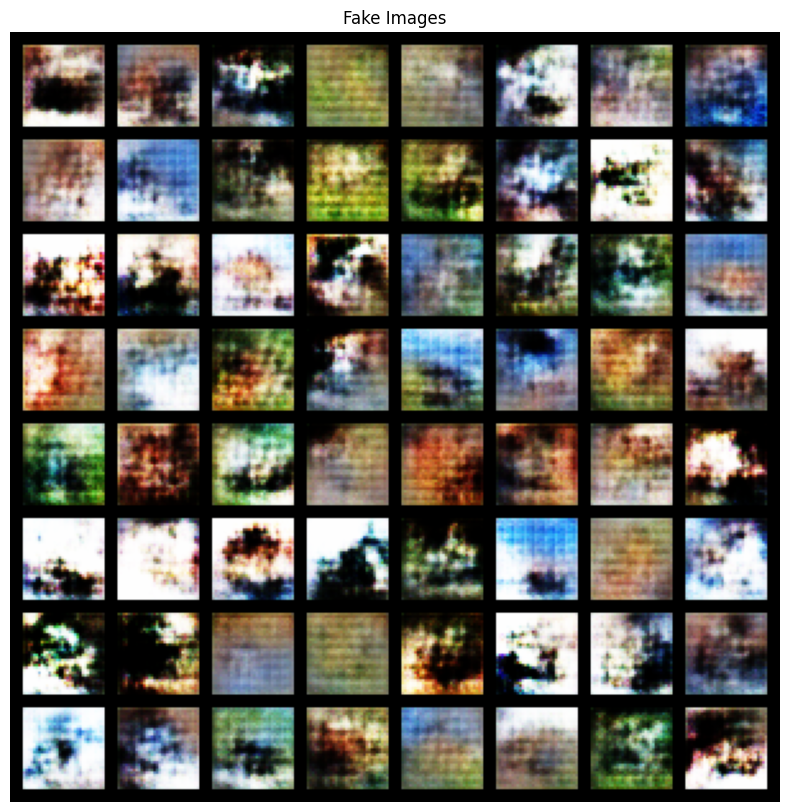

In [ ]:
# To use this, execute first cell, then Discriminator and Generator cells


def find_latest_checkpoint_directory():
    dates = os.listdir(f"{OUTPUT_DIRECTORY}")
    assert dates, "There are no saved generator states! Train a new one 🙏"
    dates.sort(
        key=lambda date: datetime.strptime(date, "%d-%m-%Y_%H:%M:%S"),
        reverse=True,
    )
    print(f"Picked output directory: {dates[0]}")
    return f"{OUTPUT_DIRECTORY}/{dates[0]}"


def find_latest_generator_path():
    checkpoints_directory = f"{latest_checkpoint_directory}/model_checkpoints/"
    generators = os.listdir(checkpoints_directory)
    generators.sort(key=lambda generator: generator, reverse=True)
    print(f"Picked generator: {generators[0]}")
    return f"{latest_checkpoint_directory}/model_checkpoints/{generators[0]}"


def load_latest_generator():
    generator = Generator().to(device)
    path = find_latest_generator_path()
    generator.load_state_dict(torch.load(path))
    return generator


def generate_fake_images():
    fixed_noise = torch.randn(64, 100, 1, 1, device=device)
    fake_images = newest_generator(fixed_noise)
    return fake_images


def plot_fake_images():
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(
        np.transpose(
            vutils.make_grid(
                fake_images.to(device)[:64], padding=5, normalize=True
            ).cpu(),
            (1, 2, 0),
        )
    )


latest_checkpoint_directory = find_latest_checkpoint_directory()
newest_generator = load_latest_generator()
fake_images = generate_fake_images()
plot_fake_images()